In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
df = pd.read_csv('RFM_ht_data.csv',low_memory=False)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [44]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
#проведите RFM анализ. В каждом подсегменте поделите пользователей на 4 класса. 
#Отсчитывайте количество дней, прошедших с момента последней покупки, с максимальной даты покупки в датасете.

In [45]:
#найдем дату последней покупки
last_date = df.InvoiceDate.max()
last_date

Timestamp('2020-09-30 00:00:00')

In [46]:
#посчитаем показатели Recency, Frequency, Monetary
rfmTable = df.groupby('CustomerCode',as_index=False)\
             .agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                   'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                   'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)
rfmTable

,CustomerCode,recency,frequency,monetary_value
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [47]:
rfmSegmentation = rfmTable

In [48]:
# разделим пользователей в каждом подсегменте на 4 класса, опираясь на  квантили
quantiles = rfmTable.quantile(q=(0.25,0.5,0.75))


def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [49]:

rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) + rfmSegmentation.F_Quartile.map(str) + rfmSegmentation.M_Quartile.map(str)

rfmSegmentation

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...,...
123728,99099927,10,1,961.10,3,4,3,343
123729,99099936,0,1,1521.78,1,4,3,143
123730,99099959,8,2,1444.56,2,3,3,233
123731,99099963,19,1,3018.91,4,4,2,442


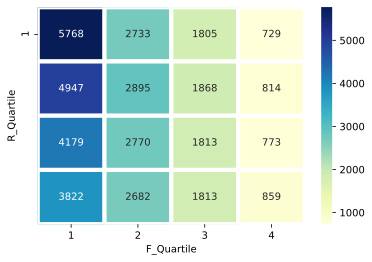

In [50]:
#сделаем визуализацию RFM анализа
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

In [51]:
##Какое максимальное кол-во покупок было совершено одним пользователем?
rfmSegmentation.sort_values('frequency',ascending=False)

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
89388,19057820,0,204,104871.80,1,1,1,111
44594,13215452,0,113,85334.40,1,1,1,111
10347,13032521,0,106,389309.92,1,1,1,111
97077,19080880,27,99,169930.72,4,1,1,411
119951,99003061,0,90,398759.35,1,1,1,111
...,...,...,...,...,...,...,...,...
58910,13272861,0,1,3312.62,1,4,2,142
58911,13272871,12,1,684.80,3,4,4,344
58913,13272875,4,1,4284.89,2,4,1,241
58914,13272878,5,1,366.01,2,4,4,244


In [52]:
###Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? 
#(Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)
rfmSegmentation.query("M_Quartile == '4'")\
               .sort_values('monetary_value',ascending=False)
#верхняя граница суммы покупок равна 765.00

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
113796,70024801,15,2,765.00,3,3,4,334
94193,19071804,4,1,765.00,2,4,4,244
11025,13036504,13,2,765.00,3,3,4,334
11336,13038952,19,1,765.00,4,4,4,444
107006,35039364,2,1,765.00,1,4,4,144
...,...,...,...,...,...,...,...,...
13696,13052590,11,1,9.50,3,4,4,344
73931,19006298,15,1,5.00,3,4,4,344
35219,13164125,28,1,2.64,4,4,4,444
108808,35076038,17,1,0.00,4,4,4,444


In [54]:
####Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
rfmSegmentation.query("F_Quartile == '1'")\
               .sort_values('frequency')
#нижняя граница по кол-ву покупок равна 4

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
6,02213129,1,4,2199.00,1,1,2,112
58850,13272658,3,4,8738.05,2,1,1,211
58870,13272725,0,4,4822.24,1,1,1,111
58882,13272763,7,4,1326.08,2,1,3,213
58886,13272778,0,4,8941.10,1,1,1,111
...,...,...,...,...,...,...,...,...
119951,99003061,0,90,398759.35,1,1,1,111
97077,19080880,27,99,169930.72,4,1,1,411
10347,13032521,0,106,389309.92,1,1,1,111
44594,13215452,0,113,85334.40,1,1,1,111


In [57]:
#####Какое максимальное количество дней может пройти с момента последней покупки 
#для того, чтобы пользователь попал в класс 2 в подсегменте R?
quantiles
#посмотрим на квантили, для второго класса соответствует 0.50 квантиль
#соответственно, чтобы пользователь попал во второй класс Recency должно пройти 8 дней

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [59]:
######Сколько пользователей попало в сегмент 111?
rfmSegmentation.query("RFMClass == '111'")\
               .CustomerCode.nunique()
#в сегмент 111 попало 9705 пользователей

9705

In [60]:
#######Сколько пользователей попало в сегмент 311?
rfmSegmentation.query("RFMClass == '311'")\
               .CustomerCode.nunique()
#в сегмент 311 попало 1609 пользователей

1609

In [64]:
########В каком RFM-сегменте самое большое кол-во пользователей?
rfmSegmentation.groupby('RFMClass', as_index=False)\
               .agg({'CustomerCode':'nunique'})\
               .sort_values('CustomerCode',ascending=False)
#в сегменте 444 больше всего пользователей(10624)

,RFMClass,CustomerCode
63,444,10624
0,111,9705
62,443,6729
47,344,6593
16,211,5847
...,...,...
55,424,63
19,214,60
3,114,60
35,314,33


In [66]:
########В каком RFM-сегменте самое маленькое кол-во пользователей?
rfmSegmentation.groupby('RFMClass', as_index=False)\
               .agg({'CustomerCode':'nunique'})\
               .sort_values('CustomerCode')
#в сегменте 414 самое маленькое кол-во пользователей(2)

,RFMClass,CustomerCode
51,414,2
35,314,33
3,114,60
19,214,60
55,424,63
...,...,...
16,211,5847
47,344,6593
62,443,6729
0,111,9705
